复现论文：Customer churn prediction using a novel meta-classifier: an investigation on transaction, Telecommunication and customer churn datasets

In [6]:
# 导入依赖包
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.combine import SMOTEENN
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import GridSearchCV
from skopt import BayesSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold

### 一、观察数据

#### 1.交易数据集(transaction dataset)

In [1]:
transaction_data = pd.read_csv('../data/transaction.csv')
# 查看数据集的基本信息
print(transaction_data.info())

NameError: name 'pd' is not defined

In [ ]:
print(transaction_data.describe())

         RowNumber    CustomerId   CreditScore           Age        Tenure  \
count  10000.00000  1.000000e+04  10000.000000  10000.000000  10000.000000   
mean    5000.50000  1.569094e+07    650.528800     38.921800      5.012800   
std     2886.89568  7.193619e+04     96.653299     10.487806      2.892174   
min        1.00000  1.556570e+07    350.000000     18.000000      0.000000   
25%     2500.75000  1.562853e+07    584.000000     32.000000      3.000000   
50%     5000.50000  1.569074e+07    652.000000     37.000000      5.000000   
75%     7500.25000  1.575323e+07    718.000000     44.000000      7.000000   
max    10000.00000  1.581569e+07    850.000000     92.000000     10.000000   

             Balance  NumOfProducts    HasCrCard  IsActiveMember  \
count   10000.000000   10000.000000  10000.00000    10000.000000   
mean    76485.889288       1.530200      0.70550        0.515100   
std     62397.405202       0.581654      0.45584        0.499797   
min         0.000000     

观察发现，transaction数据集10000条记录，14个特征，且每个特征都是不含缺失值。只有Surname\Geography\Gender是类别变量，其余都是数值型变量。

论文中对一些特征做出了解释：

(1)CreditScore特征取值范围在350-800之间，且取值都为整数。它表示贷款人对借款人在指定时间内还款的可能性的评估，得分越高的候选人越可能获得较低的贷款利率

(2)Tenure特征表示任期，反映了客户继续订阅银行的持续时间

(3)Balance特征表示余额，反映客户的资金总量

(4)NumOfProducts特征表示客户购买银行产品的数量

(5)HasCrCard特征是一个二元变量，表示客户是否拥有信用卡

(6)IsActiveMember特征是一个二元变量，表示是否是活跃客户

(7)EstimatedSalary特征表示对客户收入的预估


**注意，Exited特征是交易数据集的标签！**

In [ ]:
transaction_data["Exited"].value_counts()

Exited
0    7963
1    2037
Name: count, dtype: int64

可以看到我们的标签变量是类别不平衡的，0表示未放弃银行服务的，1表示放弃银行服务的。

#### 2.电信数据集(Telecommunication dataset)

In [ ]:
telecom_data = pd.read_csv('../data/telecommunication.csv')

In [ ]:
print(telecom_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [ ]:
print(telecom_data.describe())

       SeniorCitizen       tenure  MonthlyCharges
count    7043.000000  7043.000000     7043.000000
mean        0.162147    32.371149       64.761692
std         0.368612    24.559481       30.090047
min         0.000000     0.000000       18.250000
25%         0.000000     9.000000       35.500000
50%         0.000000    29.000000       70.350000
75%         0.000000    55.000000       89.850000
max         1.000000    72.000000      118.750000


电信数据集共有7043条数据，21个特征。其中除了SeniorCitizen\tenure\MonthlyCharges为数值型变量，其余全为类别变量。

论文中对这些特征的描述：

“SeniorCitizen”表示客户是否为老年人

“Partner”表示客户是否有合作伙伴

“Dependents”表示客户是否有家属。此数据集包括每个客户已登记的服务

“PhoneService”显示客户是否有电话服务

“MultipleLines”显示客户是否有多条线路

“InternetService”表示客户的互联网服务提供商

“OnlineSecurity”指定客户是否有在线安全

“OnlineBackup”确认客户是否有在线备份

“DeviceProtection”确认客户是否有设备保护

“TechSupport”确定客户是否有技术支持

“StreamingTV”表示客户是否电视

“StreamingMovies”引用客户是否有流电影。

该数据集还包含客户帐户信息：

“tenure”分配客户在公司的月数

“Contract”分配客户的合同期限，例如每月，一年或两年

“PaperlessBilling”推断客户是否选择了无纸化账单，而“PaymentMethod”指客户的付款方式，如电子支票、邮寄支票、银行转账或信用卡。

“MonthlyCharges”指的是每月向客户收取的费用，而“TotalCharges”反映的是向客户收取的总费用。

“Churn”是我们的标签，表示用户是否在上个月离开。

In [ ]:
telecom_data["Churn"].value_counts()

Churn
No     5174
Yes    1869
Name: count, dtype: int64

未离开的用户有5174个，离开的用户有1869个，依旧是类别不平衡。

#### 3.客户流失数据集(Customer Chrun Dataset)

In [ ]:
customer_churn_data = pd.read_excel('../data/customer_churn.xlsx')

In [ ]:
print(customer_churn_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   CustomerID                  100000 non-null  int64  
 1   Name                        100000 non-null  object 
 2   Age                         100000 non-null  int64  
 3   Gender                      100000 non-null  object 
 4   Location                    100000 non-null  object 
 5   Subscription_Length_Months  100000 non-null  int64  
 6   Monthly_Bill                100000 non-null  float64
 7   Total_Usage_GB              100000 non-null  int64  
 8   Churn                       100000 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 6.9+ MB
None


In [ ]:
print(customer_churn_data.describe())

          CustomerID            Age  Subscription_Length_Months  \
count  100000.000000  100000.000000               100000.000000   
mean    50000.500000      44.027020                   12.490100   
std     28867.657797      15.280283                    6.926461   
min         1.000000      18.000000                    1.000000   
25%     25000.750000      31.000000                    6.000000   
50%     50000.500000      44.000000                   12.000000   
75%     75000.250000      57.000000                   19.000000   
max    100000.000000      70.000000                   24.000000   

        Monthly_Bill  Total_Usage_GB          Churn  
count  100000.000000   100000.000000  100000.000000  
mean       65.053197      274.393650       0.497790  
std        20.230696      130.463063       0.499998  
min        30.000000       50.000000       0.000000  
25%        47.540000      161.000000       0.000000  
50%        65.010000      274.000000       0.000000  
75%        82.6400

客户流失数据集共有100000条数据和9个特征。

论文对特征的描述：

“Location”指定客户的地理位置，选项包括休斯顿、洛杉矶、迈阿密、芝加哥和纽约。

“Subscription_Length_Months”表示客户已订阅的月数。

“Monthly_Bill”反映客户的每月账单金额

“Total_Usage_GB”定义以GB为单位的总使用量


“Churn”作为标签变量，表示客户是否流失。

In [ ]:
customer_churn_data["Churn"].value_counts()

Churn
0    50221
1    49779
Name: count, dtype: int64

Chrun这个标签的两类基本上是平衡的。

### 二、数据预处理

论文的清理过程：为了预处理数据，我们开始进行数据清理。这涉及进行探索性数据分析（EDA），以确保所有要素都具有正确的数据类型，处理缺失值，从数据集中消除重复记录和离群值，并检查罕见类别。

In [2]:
# 首先删除诸如客户id、姓名这些对预测没有帮助的特征
transaction_data = transaction_data.drop(columns=['RowNumber','CustomerId', 'Surname'])
telecom_data = telecom_data.drop(columns=['customerID'])
customer_churn_data = customer_churn_data.drop(columns=['CustomerID', 'Name'])

NameError: name 'transaction_data' is not defined

#### 1.缺失值处理并检查各个特征是否都具有正确的类别

In [ ]:
# 交易数据集
print(transaction_data.isnull().sum())

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64


交易数据无缺失值且各个特征的类型都正常

In [ ]:
# 电信数据集
# TotalCharges按理来说应该是float类型，但实际是object类型，需要转换成float类型
telecom_data['TotalCharges'] = pd.to_numeric(telecom_data['TotalCharges'], errors='coerce')


In [ ]:
print(telecom_data['TotalCharges'].isnull().sum())

11


TotalCharges有11个缺失值。

我们使用该列的均值来填充这些缺失值

In [ ]:
telecom_data['TotalCharges'] = telecom_data['TotalCharges'].fillna(telecom_data['TotalCharges'].mean())
print(telecom_data['TotalCharges'].isnull().sum())

0


In [ ]:
# 客户流失数据集
print(customer_churn_data.isnull().sum())

Age                           0
Gender                        0
Location                      0
Subscription_Length_Months    0
Monthly_Bill                  0
Total_Usage_GB                0
Churn                         0
dtype: int64


客户数据也无缺失值

#### 2.删除重复值和离群值

In [ ]:
# 检查重复记录数量
print("交易数据集重复记录数量:", transaction_data.duplicated().sum())
print("电信数据集重复记录数量:", telecom_data.duplicated().sum())
print("客户流失数据集重复记录数量:", customer_churn_data.duplicated().sum())

交易数据集重复记录数量: 0
电信数据集重复记录数量: 22
客户流失数据集重复记录数量: 0


In [ ]:
# 删除重复记录
transaction_data = transaction_data.drop_duplicates()
telecom_data = telecom_data.drop_duplicates()
customer_churn_data = customer_churn_data.drop_duplicates()

# 再检查一遍
print("交易数据集重复记录数量:", transaction_data.duplicated().sum())
print("电信数据集重复记录数量:", telecom_data.duplicated().sum())
print("客户流失数据集重复记录数量:", customer_churn_data.duplicated().sum())

交易数据集重复记录数量: 0
电信数据集重复记录数量: 0
客户流失数据集重复记录数量: 0


In [ ]:
# 我们使用IQR方法来检测离群值
def remove_outliers_iqr(data, numerical_features):
    # 隔离原始数据和处理后的数据
    data_clean = data.copy()

    for feature in numerical_features:
        Q1 = data_clean[feature].quantile(0.25)
        Q3 = data_clean[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        data_clean = data_clean[(data_clean[feature] >= lower_bound) & (data_clean[feature] <= upper_bound)]
    return data_clean

In [ ]:
transaction_numerical_features = ['CreditScore', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary', 'Age']
telecom_numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
customer_churn_numerical_features = ["Age", 'Subscription_Length_Months', 'Monthly_Bill', 'Total_Usage_GB']

In [ ]:
transaction_data_clean = remove_outliers_iqr(transaction_data, transaction_numerical_features)
telecom_data_clean = remove_outliers_iqr(telecom_data, telecom_numerical_features)
customer_churn_data_clean = remove_outliers_iqr(customer_churn_data, customer_churn_numerical_features)


#### 3.检查罕见类别

我们通过可视化的技术检查数据中是否存在罕见类别

In [ ]:
# 交易数据集的类别变量
transaction_categorical_features = ['Geography', 'Gender']

# 电信数据集的类别变量
telecom_categorical_features = ['gender', 'Partner', 'Dependents', 'PhoneService', 
                                'MultipleLines', 'InternetService', 'OnlineSecurity', 
                                'OnlineBackup', 'DeviceProtection', 'TechSupport', 
                                'StreamingTV', 'StreamingMovies', 'Contract', 
                                'PaperlessBilling', 'PaymentMethod','Churn']

# 客户流失数据集的类别变量
customer_churn_categorical_features = ['Gender','Location']

In [ ]:
# 可视化类别变量
def visualize_categorical_features(data, categorical_features):
    for feature in categorical_features:
        num = len(data[feature].value_counts())  # 每个分类特征有多少个类别
        plt.figure(figsize=(4, (num // 4) + 1))
        sns.countplot(y=feature, data=data, order=data[feature].value_counts().index)
        plt.title(f'{feature} Distribution')
        plt.show()

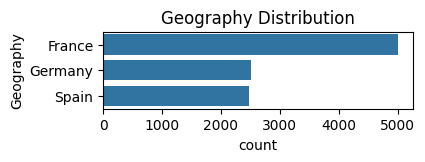

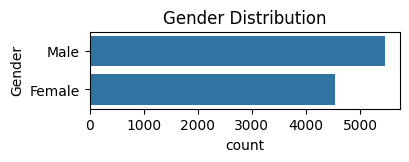

In [ ]:
# 检查交易数据集
visualize_categorical_features(transaction_data, transaction_categorical_features)

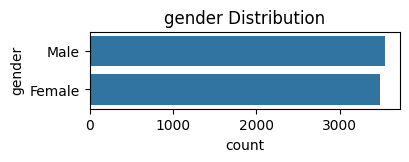

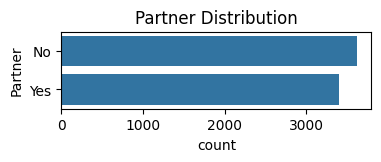

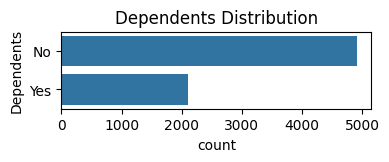

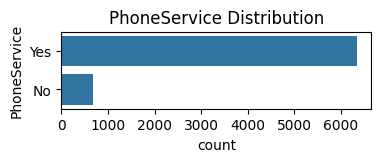

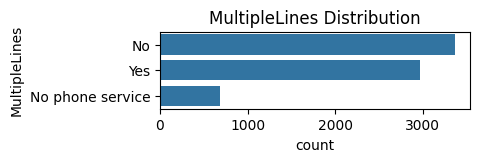

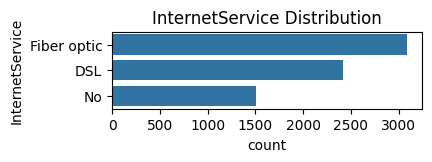

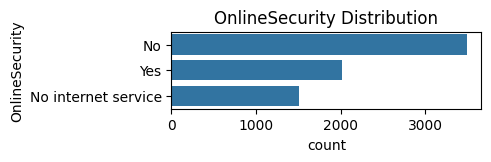

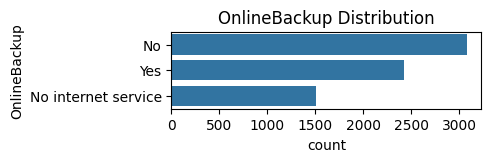

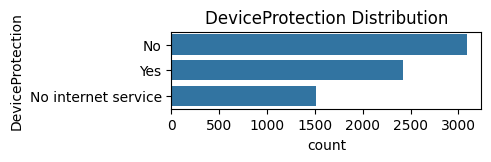

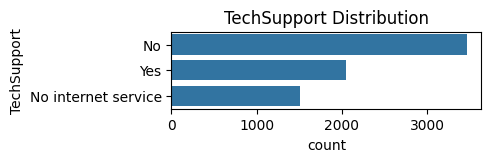

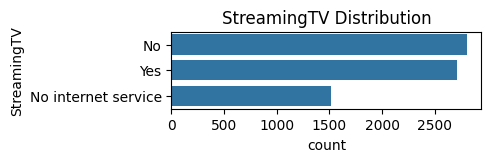

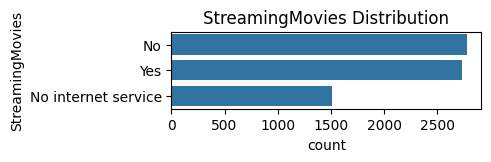

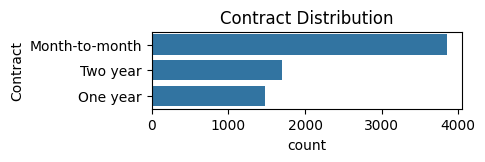

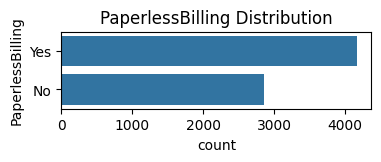

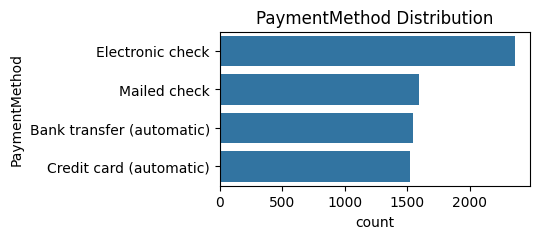

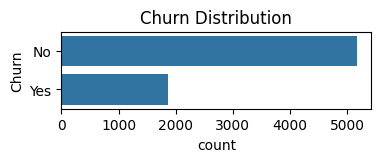

In [ ]:
# 检查电信数据集
visualize_categorical_features(telecom_data, telecom_categorical_features)


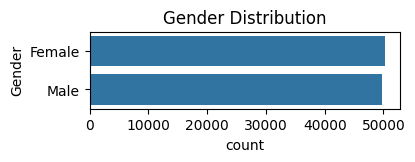

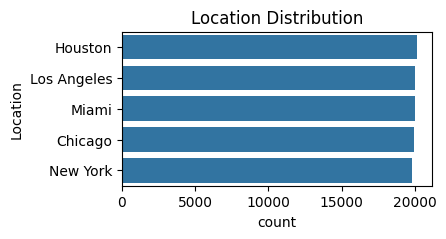

In [ ]:
# 检查客户流失数据集
visualize_categorical_features(customer_churn_data, customer_churn_categorical_features)

以1%为阈值的话，其实这三个数据集中并没有罕见类别，不需要处理。

#### 4.将类别数据编码为数值

论文中统一使用LabelEncoder来对类别数据进行编码，但这实际会给这些类别一些顺序上的含义，对于地区等无序类别我们需要使用OneHotEncoder

统筹考虑类别的顺序和独热编码可能导致的维度爆炸问题，我们对二元类别变量使用LabelEncoder，对于无序类别变量使用OneHotEncoder

In [ ]:
# 创建编码器
# 论文中使用到的编码器
def encoder_essay(data, categorical_features):
    # 隔离开原始数据和编码后的数据
    data_encoded = data.copy()

    le = LabelEncoder()  # 将类别编码为0-n-1之间的数值
    for category in categorical_features:
        data_encoded[category] = le.fit_transform(data_encoded[category])
    
    return data_encoded

# 改进编码器
def encoder(data, categorical_features):
    # 隔离开原始数据和编码后的数据
    data_encoded = data.copy()

    le = LabelEncoder()
    for category in categorical_features:
        if data_encoded[category].nunique() == 2:
            data_encoded[category] = le.fit_transform(data_encoded[category])
        else:
            data_encoded = pd.concat([data_encoded, pd.get_dummies(data_encoded[category], dtype=int, prefix=category)], axis=1)
            data_encoded.drop(category, axis=1, inplace=True)
    return data_encoded

In [ ]:
# 按照论文的方式编码
transaction_data_essay = encoder_essay(transaction_data, transaction_categorical_features)
telecom_data_essay = encoder_essay(telecom_data, telecom_categorical_features)
customer_churn_data_essay = encoder_essay(customer_churn_data, customer_churn_categorical_features)

# 按照改进的编码器编码
transaction_data_encoder = encoder(transaction_data, transaction_categorical_features)  # 总共有13个特征
telecom_data_encoder = encoder(telecom_data, telecom_categorical_features) #总共有42个特征
customer_churn_data_encoder = encoder(customer_churn_data, customer_churn_categorical_features)  # 总共有11个特征

In [ ]:
# 现在应该所有的特征都是数值型特征了
def check_data_type(data):
    flag = True
    for column in data.columns:
        if data[column].dtype != 'float64' and data[column].dtype != 'int64':
            flag = False
            break
    return flag
print(check_data_type(transaction_data_encoder))
print(check_data_type(telecom_data_encoder))
print(check_data_type(customer_churn_data_encoder))


True
True
True


#### 5.特征标准化

排除不同特征的尺度对后续训练模型的影响。这里统一使用StandardScaler来进行标准化。（把所有数值型数据标准化为均值为0，标准差为1）

In [ ]:
def standardize_data(data, numerical_features):
    # 隔离原始数据和标准化后的数据
    data_standardized = data.copy()

    scaler = StandardScaler()
    for feature in numerical_features:
        data_standardized[feature] = scaler.fit_transform(data_standardized[[feature]])
    return data_standardized

In [ ]:
# 使用论文编码器的数据
transaction_data_essay_standardized = standardize_data(transaction_data_essay, transaction_numerical_features)
telecom_data_essay_standardized = standardize_data(telecom_data_essay, telecom_numerical_features)
customer_churn_data_essay_standardized = standardize_data(customer_churn_data_essay, customer_churn_numerical_features)

# 使用改进编码器的数据
transaction_data_encoder_standardized = standardize_data(transaction_data_encoder, transaction_numerical_features)
telecom_data_encoder_standardized = standardize_data(telecom_data_encoder, telecom_numerical_features)
customer_churn_data_encoder_standardized = standardize_data(customer_churn_data_encoder, customer_churn_numerical_features)

# 检查标准化后的数据
print(transaction_data_essay_standardized.head())

   CreditScore  Geography  Gender       Age    Tenure   Balance  \
0    -0.326221          0       0  0.293517 -1.041760 -1.225848   
1    -0.440036          2       0  0.198164 -1.387538  0.117350   
2    -1.536794          0       0  0.293517  1.032908  1.333053   
3     0.501521          0       0  0.007457 -1.387538 -1.225848   
4     2.063884          2       0  0.388871 -1.041760  0.785728   

   NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  Exited  
0      -0.911583          1               1         0.021886       1  
1      -0.911583          0               1         0.216534       0  
2       2.527057          1               0         0.240687       1  
3       0.807737          0               0        -0.108918       0  
4      -0.911583          1               1        -0.365276       0  


#### 6.类别不平衡的处理

我们使用论文中提到的SMOTE-ENN(Synthetic Minority Oversampling Technique - Edited Nearest Neighbors)方法处理类别不平衡问题。

ENN是编辑的最邻近算法，它对于每一个样本点 x，找到它的 k 个最近邻（通常 k=3）。查看这 k 个邻居的标签，与样本 x 自己的标签进行比较。如果 x 的标签与它的多数邻居标签 不一致，则认为 x 可能是 噪声样本 或 边界样本，将其删除。

Python中已经有库实现了SMOTE-ENN算法

In [ ]:
# 到这里我们已经完成了划分训练集和测试集之前的所有步骤
data_essay = {"transaction":transaction_data_essay_standardized, 
              "telecom":telecom_data_essay_standardized, 
              "customer_churn":customer_churn_data_essay_standardized}
data_encoder = {"transaction":transaction_data_encoder_standardized, 
                "telecom":telecom_data_encoder_standardized, 
                "customer_churn":customer_churn_data_encoder_standardized}
    

In [ ]:
# 处理类别不平衡的函数
def handle_imbalance(X_train, y_train):
    smote_enn = SMOTEENN()
    X_resampled, y_resampled = smote_enn.fit_resample(X_train, y_train)
    return X_resampled, y_resampled


In [ ]:
# 数据加载函数
def data_loader(datasets_dict, dataset_name, test_size=0.3, random_state=42):
    '''
    数据加载函数
    参数：
        datasets_dict: 数据集字典
        dataset_name: 数据集名称:有['transaction', 'telecom', 'customer_churn']
        test_size: 测试集的比例,默认为30%
        random_state: 随机种子,默认为42
    返回: 
        训练集(若是transaction则处理完类别不平衡后)和测试集的特征和标签,是一个四元组(X_train, X_test, y_train, y_test)
    '''
    if dataset_name == "transaction":
        X = datasets_dict[dataset_name].drop(columns=['Exited'])
        y = datasets_dict[dataset_name]['Exited']
        # 划分数据集并处理类别不平衡
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
        X_train_resampled, y_train_resampled = handle_imbalance(X_train, y_train)
        return X_train_resampled, X_test, y_train_resampled, y_test
    elif dataset_name == "telecom":
        X = datasets_dict[dataset_name].drop(columns=['Churn'])
        y = datasets_dict[dataset_name]['Churn']
        # 划分数据集
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
        return X_train, X_test, y_train, y_test
    elif dataset_name == "customer_churn":
        X = datasets_dict[dataset_name].drop(columns=['Churn'])
        y = datasets_dict[dataset_name]['Churn']
        # 划分数据集
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
        return X_train, X_test, y_train, y_test

In [ ]:
transaction_train, transaction_test, transaction_y_train, transaction_y_test = data_loader(data_encoder, "transaction")
transaction_y_train.value_counts()

/opt/anaconda3/envs/data_mining/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/envs/data_mining/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/envs/data_mining/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Exited
1    4877
0    3600
Name: count, dtype: int64

可以看到两个类别的数量没有差别太多

### 三、特征选择

论文中使用到了Permutation Feature Importance(PFS)和SelectKBest两种方法对特征进行筛选。

#### 1.Permutation Feature Importance(PFS)

论文的思路：先不做特征选择训练一个基准的随机森林分类模型，再以该模型得出特征重要性。

**注意：PFS是一种有监督的依赖于训练好的模型的特征选择方法，因此PFS经常在超参数优化之后**

In [3]:
def select_features_pfs(model, X_train, y_train, method = None, **kwargs):
    '''
    pfs特征选择函数
    参数：
        model: 训练好的模型
        X_train: 训练集特征
        y_train: 训练集标签
        method: 特征选择方法，可选有'threshold','top_k','percentile','stable', 默认为None。
        **kwargs: 对应每个方法的参数
    返回：
        method不为None时，返回(特征选择后的训练数据, 被选择的特征, 特征重要性排序）；
        method为None时，返回特征重要性排序。
    '''
    # 计算特征重要性
    perm_importance = permutation_importance(model, X_train, y_train, random_state=42)
    feature_importance = pd.DataFrame({'feature':X_train.columns, 
                                        'importance':perm_importance.importances_mean,
                                        'std':perm_importance.importances_std}).sort_values(by='importance', ascending=False)
    # 根据method选择特征
    if method == 'threshold':
        threshold = kwargs.get('threshold', 0.01)
        X_train_selected = feature_importance[feature_importance['importance'] > threshold]
        feature_selected = X_train_selected['feature'].tolist()
        return X_train_selected, feature_selected, feature_importance
    elif method == 'top_k':
        k = kwargs.get('k', 10)
        X_train_selected = feature_importance.head(k)
        feature_selected = X_train_selected['feature'].tolist()
        return X_train_selected, feature_selected, feature_importance
    elif method == 'percentile':
        percentile = kwargs.get('percentile', 0.75)
        threshold = feature_importance['importance'].quantile(percentile)
        X_train_selected = feature_importance[feature_importance['importance'] > threshold]
        feature_selected = X_train_selected['feature'].tolist()
        return X_train_selected, feature_selected, feature_importance
    elif method == 'stable':
        mean_importance = feature_importance['importance'].mean()
        threshold = kwargs.get('threshold', 0.01)
        X_train_selected = feature_importance[(feature_importance['std'] < threshold) & 
                                              (feature_importance['importance'] > mean_importance)]  # 标准差小于阈值且重要性大于均值的特征
        feature_selected = X_train_selected['feature'].tolist()
        return X_train_selected, feature_selected, feature_importance
    else:
        return feature_importance

#### 2.SelectKBest

**注意：SelectKBest是一种无监督的特征选择方法，它基于统计检验，不依赖于训练好的模型，因此超参数K可以一起跟随模型的超参数一起优化**

### 四、超参数优化

#### 1.GridSearchCV

In [7]:
# 在这一步中同时进行selectKBest的优化和模型超参数的优化
def grid_search_cv(model, X_train, y_train, param_grid, n_splits=5, scoring='accuracy'):
    '''
    网格搜索超参数优化函数(交叉验证策略为StratifiedKFold)
    我们在这个函数中同时进行selectKBest的优化和模型超参数的优化，selectKBest的评分函数为f_classif。
    参数：
        model: 机器学习模型
        X_train: 训练集特征
        y_train: 训练集标签
        param_grid: 与模型对应的超参数网格
        n_splits: 交叉验证的折数,默认为5
        scoring: 评分标准,默认为accuracy
    返回：
        best_model: 最优模型
        best_params: 最优超参数
        selected_features: 选择的特征
    '''
    pipeline = Pipeline([
        ('selector', SelectKBest(score_func=f_classif)),
        ('model', model(random_state=123))
    ])
    grid_search = GridSearchCV(pipeline, param_grid, 
                               cv=StratifiedKFold(n_splits=n_splits, random_state=123, shuffle=True), 
                               scoring=scoring,
                               n_jobs=-1,
                               verbose=0)
    grid_search.fit(X_train, y_train)

    # 获取选择的特征
    selected_features = X_train.columns[grid_search.best_estimator_.named_steps['selector'].get_support()].tolist()

    # 获取最优模型
    best_model = grid_search.best_estimator_

    # 获取最优超参数
    best_params = grid_search.best_params_
    
    # 输出最优得分
    print(f"最优得分: {grid_search.best_score_}")
    return best_model, best_params, selected_features

#### 2.BayesSearchCV

In [8]:
def bayes_search_cv(model, X_train, y_train, param_grid, n_splits=5, scoring='accuracy'):
    '''
    贝叶斯搜索超参数优化函数(交叉验证策略为StratifiedKFold)
    参数：
        model: 机器学习模型
        X_train: 训练集特征
        y_train: 训练集标签
        param_grid: 与模型对应的超参数网格
        n_splits: 交叉验证的折数,默认为5
        scoring: 评分标准,默认为accuracy
    返回：
        best_model: 最优模型
        best_params: 最优超参数
    '''
    bayes_search = BayesSearchCV(model(random_state=123), param_grid, 
                                cv=StratifiedKFold(n_splits=n_splits, random_state=123, shuffle=True), 
                                scoring=scoring,
                                n_jobs=-1,
                                verbose=0)
    bayes_search.fit(X_train, y_train)

    # 获取最优模型
    best_model = bayes_search.best_estimator_

    # 获取最优超参数
    best_params = bayes_search.best_params_
    
    # 输出最优得分
    print(f"最优得分: {bayes_search.best_score_}")
    return best_model, best_params


特征选择和超参数优化的执行步骤：

SelectKBest (第一步)
原因：这是无监督的特征选择方法，不依赖于训练好的模型
作用：快速筛选出最重要的K个特征，减少后续计算复杂度
优势：基于统计检验，计算快速，可以与其他超参数一起优化

GridSearchCV (第二步)
原因：在特征选择后进行超参数优化
作用：对模型的主要超参数进行网格搜索
建议：优化那些离散的、搜索范围较小的超参数（如n_estimators, max_depth等）

BayesSearchCV (第三步)
原因：在GridSearchCV的基础上进一步精细调优
作用：对连续参数或大范围参数进行贝叶斯优化
建议：优化那些连续的、搜索范围较大的超参数（如learning_rate, regularization参数等）

Permutation Feature Importance (PFS) (第四步)
原因：这是有监督的特征选择方法，需要训练好的模型
作用：基于已优化模型的特征重要性进行最终特征筛选
优势：可以进一步剔除不重要的特征，提高模型泛化能力